## Week 4 - From Integrated Dataset to Predictive Model.

### We will build and evaluate the first regression model that predicts miRNA regulatory behavior (TargetScan-derived labels) from intrinsic sequence features (miRBase-derived features).

### This Includes:

#### Finalize a clean modeling dataset
#### Define labels and predictors clearly
#### Train a baseline linear regression model
#### Evaluate performance using train/test split
#### Interpret biological meaning of model coefficients

In [1]:
# First, let's open our integrated table

import pandas as pd

df_final = pd.read_csv('../data/targetscan_mirbase_integrated_data.csv')
df_final.head()

,miRNA,mean_context_score,min_context_score,n_targets,sequence,length,GC_content,seed,seed_GC_content,seed_group_size
0,hsa-let-7a-5p,-0.282952,-0.809,1386,UGAGGUAGUAGGUUGUAUAGUU,22.0,0.363636,GAGGUAG,0.571429,11.0
1,hsa-let-7b-5p,-0.281561,-0.809,1386,UGAGGUAGUAGGUUGUGUGGUU,22.0,0.454545,GAGGUAG,0.571429,11.0
2,hsa-let-7c-5p,-0.283001,-0.809,1386,UGAGGUAGUAGGUUGUAUGGUU,22.0,0.409091,GAGGUAG,0.571429,11.0
3,hsa-let-7d-5p,-0.294442,-0.827,1386,AGAGGUAGUAGGUUGCAUAGUU,22.0,0.409091,GAGGUAG,0.571429,11.0
4,hsa-let-7e-5p,-0.282975,-0.809,1386,UGAGGUAGGAGGUUGUAUAGUU,22.0,0.409091,GAGGUAG,0.571429,11.0


In [2]:
# Then some QC

df_final.isna().sum()

miRNA                 0
mean_context_score    0
min_context_score     0
n_targets             0
sequence              1
length                1
GC_content            1
seed                  1
seed_GC_content       1
seed_group_size       1
dtype: int64

In [3]:
# Let's explore this missing value. Looks like this might be hsa-miR-325-3p, as this one came from targetscan, which did not include miRNA features

df_final[df_final['sequence'].isna()]

,miRNA,mean_context_score,min_context_score,n_targets,sequence,length,GC_content,seed,seed_GC_content,seed_group_size
167,hsa-miR-325-3p,-0.104456,-0.58,2475,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# Missing information for hsa-miR-325-3p can be filled with some help. Let's use the sequence 5'-UUUAUUGAGGACCUCCUAUCAA-3' based on MirGeneDB and
# this paper: https://onlinelibrary.wiley.com/doi/10.1155/2023/6882851

# Based on earlier seed definition, we define this as being UUAUUGA (intrinsic seed sequence)

# Let us start by defining the sequence for hsa-miR-325-3p

seq_325 = 'UUUAUUGAGGACCUCCUAUCAA'

In [5]:
# Compute features for sequence

# length
length_325 = len(seq_325)

# GC content

GC_325 = (seq_325.count('G') + seq_325.count('C')) / length_325

# seed
seed_325 = seq_325[1:8]

# seed GC content

seed_GC_325 = (seed_325.count('G') + seed_325.count('C')) / len(seed_325)

# Check all

print(length_325, GC_325, seed_325, seed_GC_325)




22 0.36363636363636365 UUAUUGA 0.14285714285714285


In [6]:
# Insert hsa-miR-325-3p info into df_final

mask = df_final['miRNA'] == 'hsa-miR-325-3p'

# insert info

df_final.loc[mask, 'sequence'] = seq_325
df_final.loc[mask, 'length'] = length_325
df_final.loc[mask, 'GC_content'] = GC_325
df_final.loc[mask, 'seed'] = seed_325
df_final.loc[mask, 'seed_GC_content'] = seed_GC_325 


In [7]:
# Finally, let's place the miRNA in a seed group size by updating globally (full table)

seed_counts = df_final['seed'].value_counts()

df_final['seed_group_size'] = df_final['seed'].map(seed_counts)

In [8]:
# Let's see if it all checks out

display(df_final[df_final['miRNA'] == 'hsa-miR-325-3p'])
display(df_final.isna().sum())

,miRNA,mean_context_score,min_context_score,n_targets,sequence,length,GC_content,seed,seed_GC_content,seed_group_size
167,hsa-miR-325-3p,-0.104456,-0.58,2475,UUUAUUGAGGACCUCCUAUCAA,22.0,0.363636,UUAUUGA,0.142857,1


miRNA                 0
mean_context_score    0
min_context_score     0
n_targets             0
sequence              0
length                0
GC_content            0
seed                  0
seed_GC_content       0
seed_group_size       0
dtype: int64

In [9]:
# save to csv

df_final.to_csv('../data/targetscan_mirbase_integration_325-3p.csv', index=False)

## Next we need to define a dataset for modeling 

In [10]:
# Initially, we use numeric feature values to check if any of these intrinsic properties have an effect on 
# interaction score  

x = df_final[[
    'length',
    'GC_content',
    'seed_GC_content',
    'seed_group_size',
    ]]

y = df_final['mean_context_score']

# QC check
x.describe()

,length,GC_content,seed_GC_content,seed_group_size
count,297.000000,297.000000,297.000000,297.000000
mean,22.000000,0.461651,0.477633,2.481481
std,0.858188,0.097593,0.159497,2.372526
min,17.000000,0.227273,0.000000,1.000000
25%,22.000000,0.391304,0.428571,1.000000
50%,22.000000,0.454545,0.428571,2.000000
75%,22.000000,0.523810,0.571429,2.000000
max,25.000000,0.772727,1.000000,10.000000


In [11]:
# Let's make a quick correlation inspection

df_final[[
    'length',
    'GC_content',
    'seed_GC_content',
    'seed_group_size',
    'mean_context_score'
    ]].corr()

,length,GC_content,seed_GC_content,seed_group_size,mean_context_score
length,1.000000,-0.138195,0.014104,0.074667,-0.135587
GC_content,-0.138195,1.000000,0.551771,-0.194219,-0.152697
seed_GC_content,0.014104,0.551771,1.000000,-0.039679,-0.580493
seed_group_size,0.074667,-0.194219,-0.039679,1.000000,-0.145179
mean_context_score,-0.135587,-0.152697,-0.580493,-0.145179,1.000000


## correlation check shows a significant correlation between seed GC content and context score, i.e. the higher seed GC content, the stronger miRNA repression is 

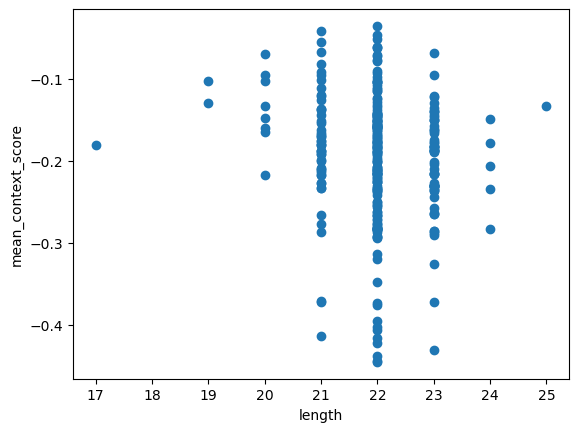

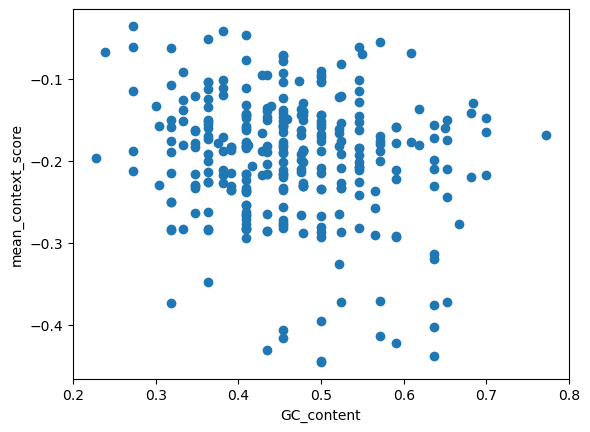

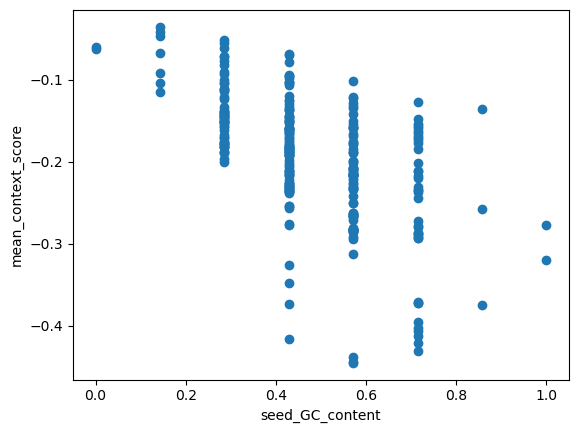

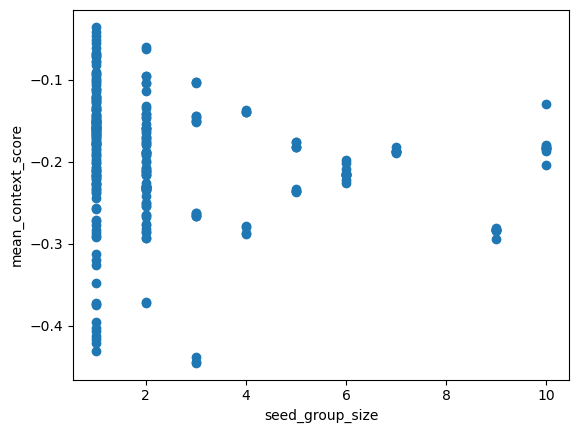

In [12]:
# Let's make a scatter plot to visualize

import matplotlib.pyplot as plt

for col in x.columns:
    plt.scatter(df_final[col], df_final['mean_context_score'])
    plt.xlabel(col)
    plt.ylabel('mean_context_score')
    plt.show()


In [13]:
# verify scikit-learn install

import sklearn
sklearn.__version__

'1.7.1'

In [14]:
# Train/test split of full model

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42
)

In [15]:
# Model fit to linear regression

from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(x_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [16]:
# Evaluate model

from sklearn.metrics import r2_score, mean_squared_error

y_pred = model.predict(x_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

r2, mse

(0.40813370425757634, 0.0036434602849535628)

## So, the relationship between the features and label accounts for 40 % of the variation in the data
## In other words, the relationship explains about 40 % of the variation in the data, a signficant observation in biology
## However, we have looked at multiple features. Do they contribute equally to the variation, or does one stand out. Let's look a bit closer 

In [17]:
# Looking at each coefficient might tell us more about which feature (generally known as predictor variable) contributes most to the 
# context score (i.e. the label)

pd.Series(model.coef_, index=x.columns)


length            -0.007582
GC_content         0.149845
seed_GC_content   -0.344137
seed_group_size   -0.002985
dtype: float64

## Looks like the GC content of the seed contributes a lot to the variation. It would make sense to make a simple linear regression with seed GC content as the predictor variable (feature) and context score as label, and compare the results to the full model

In [18]:
# First, we re-define the variables

X = df_final[['seed_GC_content']]

y = df_final['mean_context_score']

In [19]:
# Train/test split of simple model

import sklearn
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [20]:
# Model fit to linear regression

from sklearn.linear_model import LinearRegression

model_seedGC = LinearRegression()
model_seedGC.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [21]:
# Model evaluation

from sklearn.metrics import r2_score, mean_squared_error

Y_pred = model_seedGC.predict(X_test)

r2_seedGC = r2_score(y_test, Y_pred)
mse_seedGC = mean_squared_error(y_test, Y_pred)

r2_seedGC, mse_seedGC

(0.3151255617176948, 0.004216007625390115)

In [22]:
# Looking at the difference between full and simple model - do the other features contribute to variation or does it only come from the 
# seed GC content? 

print(r2 - r2_seedGC)

0.09300814253988154


## Alone, seed GC explains about 31,5 % of the variation of the context score. And a 0.093 difference from the full model indicates that one or more of the other features (sequence length, sequence GC content, and seed group size) in fact do contribute to the observed variation - about 9.3 % in total 

In [23]:
# Model diagnostics - QC of baseline model

residuals = y_test - y_pred
residuals

167   -0.010523
211    0.028804
63    -0.034040
154    0.104677
5     -0.011959
77    -0.125018
183    0.001835
158   -0.041625
9     -0.217628
139    0.041376
285    0.000627
78     0.066338
92    -0.088623
101   -0.001621
42    -0.024124
222    0.025192
283    0.088929
33     0.099838
263    0.057957
148   -0.028488
245   -0.012072
45     0.015408
60    -0.066255
46     0.026683
278    0.046473
237    0.061705
175    0.077073
234   -0.010066
17    -0.004339
279    0.027895
111    0.013229
219   -0.002525
24     0.053882
82    -0.044624
7     -0.024049
75    -0.006620
108    0.021323
84    -0.033611
90     0.013962
73     0.000748
116    0.079666
126   -0.069801
233    0.100623
59     0.112858
195    0.000645
208    0.054036
97    -0.024199
185    0.109818
176    0.080661
124    0.005109
93    -0.094813
294   -0.011419
182   -0.001145
275    0.063341
192    0.078795
292    0.012282
25     0.038481
224   -0.008151
6     -0.018639
181    0.010629
Name: mean_context_score, dtype: float64

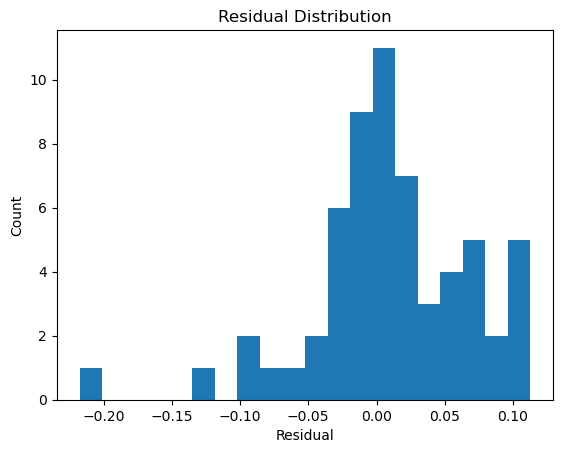

In [24]:
# visualizing via histogram

plt.hist(residuals, bins=20)
plt.xlabel('Residual')
plt.ylabel('Count')
plt.title('Residual Distribution')
plt.show()

# Data moves towards 0, small skew, and no extreme outliers

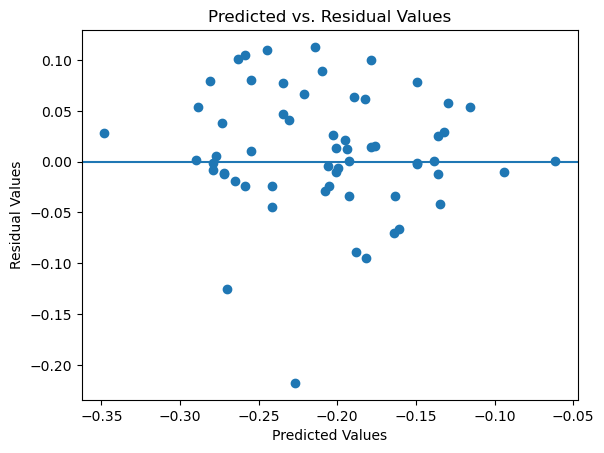

In [25]:
# Predicted plot

plt.scatter(y_pred, residuals)
plt.axhline(0)
plt.xlabel('Predicted Values')
plt.ylabel('Residual Values')
plt.title('Predicted vs. Residual Values')
plt.show()

In [26]:
# mean of residuals

residuals.mean()

# model seems to be linear with no clear skew and no systematic bias

np.float64(0.010081946561807808)

In [27]:
# R2 adjusted

n = len(y_test) # number of samples in test samples
p = x_test.shape[1] # number of feautures
r2 = r2 # previously computed r2-value


In [28]:
# Computing adjusted R2

r2_adj = 1 - ((1 - r2)*(n - 1)/ (n - p - 1))
r2_adj

0.3650888827490364

## r2 adjusted for the full model penalizes it slightly due to complexity, with a drop to 0.365. However, there is still a real explanatory value in the difference from the simple model (seed GC). We can say about 5% of the variance in the data is explained by the other features. Its smal, but can have biological meaning

In [29]:
# Model robustness - making 5 cross validations

from sklearn.model_selection import cross_val_score

model_cv = LinearRegression()

cv_scores = cross_val_score(model_cv, x, y, cv=5, scoring='r2')

In [30]:
# Inspect cross validations

print(cv_scores)
print(cv_scores.mean())
print(cv_scores.std())


[ 0.40603833  0.28823655 -0.31021643  0.47652734  0.34221643]
0.24056044356716236
0.2824979359275286


## LOoks like the model is very unstable. Let's look at stabilizing it 

In [32]:
# Ridge Regression to reduce overfitting and handle multicollinearity
# Starting with scaling the coefficients

X_ridge = df_final[[
    'length',
    'GC_content',
    'seed_GC_content',
    'seed_group_size'
]]

y_ridge = df_final['mean_context_score']

In [34]:
# train/split

x_train, x_test, y_train, y_test = train_test_split(
    X_ridge, y_ridge, test_size=0.2, random_state=42
)

In [37]:
# scalar fit

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

x_train_scaled = scaler.fit_transform(x_train) # fit on training set only
x_test_scaled = scaler.transform(x_test) # transform testing set using the same scaler

In [39]:
#  Define Alpha Grid

import numpy as np

alphas = np.logspace(-3,3,50)

In [41]:
# Setup GridSearchCV

from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

ridge = Ridge()

grid = GridSearchCV(
    ridge, # use ridge function to perform ridge regression
    param_grid = {'alpha': alphas}, # perform on grid range and pick best alpha
    cv = 5, # 5-fold cross validation
    scoring='r2' # compute r2
)

In [42]:
# Fit on scaled training data

grid.fit(x_train_scaled, y_train)

,estimator,Ridge()
,param_grid,{'alpha': array([1.0000...00000000e+03])}
,scoring,'r2'
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,alpha,np.float64(10.985411419875572)


In [45]:
# Extracting results

best_alpha = grid.best_params_['alpha']
best_cv_r2 = grid.best_score_

print(best_alpha)
print(best_cv_r2)

10.985411419875572
0.3035867428885485


In [55]:
# Std for ridge model

#from sklearn.model_selection import cross_val_score
#from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline

ridge_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("ridge", Ridge(alpha=best_alpha))
])


cv_ridge = cross_val_score(ridge_pipeline, X_ridge, y_ridge, cv=5, scoring="r2")

print(cv_ridge.std())


0.25462347669763546


In [46]:
# Evaluate on test set

best_ridge = grid.best_estimator_

y_pred_ridge = best_ridge.predict(x_test_scaled)

from sklearn.metrics import r2_score

r2_ridge_test = r2_score(y_test, y_pred_ridge)

r2_ridge_test

0.41278425362664173

In [ ]:
# Standard deviation is high, so model seems unstable. Let's do repeated cross validations

from sklearn.model_selection import RepeatedKFold
#from sklearn.pipeline import Pipeline
#from sklearn.preprocessing import StandardScaler
#from sklearn.linear_model import Ridge
#from sklearn.model_selection import cross_val_score

rkf = RepeatedKFold(n_splits=5, n_repeats=10, random_state=42) # 5 CVs as before and repeated 10 times

ridge_pipeline = Pipeline([
   ("scaler", StandardScaler()),
   ("ridge", Ridge(alpha=best_alpha))
])

cv_ridge_repeated = cross_val_score(
    ridge_pipeline,
    X_ridge,
    y_ridge,
    cv=rkf,
    scoring="r2"
)

print(cv_ridge_repeated.mean(), cv_ridge_repeated.std())


0.37612941715069936 0.10114249694542636


In [47]:
# Let's quickly look at cross validation on the simple model, just for comparison. Maybe we can interpret more

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

model_seed = LinearRegression()

cv_seed = cross_val_score(model_seed, X, y, cv=5, scoring="r2")

print(cv_seed, 
      cv_seed.mean(),
      cv_seed.std()
)

[ 0.26919425  0.345926   -0.57408143  0.4246683   0.33035873] 0.1592131714199419 0.3699826265401246
